# 📊 Dynamic Knowledge Graph Construction for Financial Report with CAMEL

You can also check this cookbook in colab [here](https://drive.google.com/file/d/19EWVOVZl_nVCs0ERr6IEaxiXHGPObYS9/view?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>




This notebook demonstrates how to build a dynamic knowledge graph using CAMEL's Knowledge Graph Agent and Neo4j. The knowledge graph is constructed by parsing PDF documents, extracting entities and relationships, and storing them in a Neo4j database. The graph is then queried to retrieve time-based relationships.

In this notebook, you'll explore:

- **CAMEL**: A powerful multi-agent framework that enables the construction of knowledge graphs from unstructured data.
- **Neo4j**: A graph database used to store and query the knowledge graph.
- **Together and SambaVerse Models**: Large language models used to generate the knowledge graph from parsed documents.
- **Deduplication**: Techniques to ensure the uniqueness of nodes and relationships in the graph.

This setup not only demonstrates a practical application of AI-driven knowledge graph construction but also provides a flexible framework that can be adapted to other real-world scenarios requiring dynamic graph generation and querying.

## 📦 Installation

First, install the CAMEL package with all its dependencies:
Second, make sure that Neo4j is running and accessible from your local machine.

In [ ]:
pip install "camel-ai[rag]==0.2.22"

## 🚀 Launch Service

Start Neo4j service in the background((using Ubuntu as an example))

In [ ]:
neo4j start

## 🔑 Setting Up API Keys

You'll need to set up your API keys for Together and SambaVerse. This ensures that the tools can interact with external services securely.

In [ ]:
import os
import dotenv
import colorama
from getpass import getpass

dotenv.load_dotenv()

# Prompt for the TogetherAI API key securely
together_api_key = getpass('Enter Together API key: ')
os.environ["TOGETHER_API_KEY"] = together_api_key

# Prompt for the SambanovaAI API key securely
sambanova_api_key = getpass('Enter Sambanova API key: ')
os.environ["SAMBA_API_KEY"] = sambanova_api_key

# Prompt for the OpenAI API key securely
openai_api_key = getpass('Enter OpenAI API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

print(
    colorama.Fore.GREEN
    + "✅ Loading environment variables successfully."
    + colorama.Fore.RESET
)


✅ Loading environment variables successfully.


## 🛠️ Setting Up Neo4j

To store and query the knowledge graph, you'll need a Neo4j instance. If you don't have one, you can set up a local instance or use a cloud service like Neo4j Aura.

1. **Local Setup**: Download and install Neo4j Desktop from [here](https://neo4j.com/download/).
2. **Cloud Setup**: Sign up for Neo4j Aura [here](https://neo4j.com/cloud/aura/).

Once you have your Neo4j instance running, set up the connection details:

In [ ]:
# Prompt for Neo4j securely
os.environ["NEO4J_URI"] = getpass('Enter NEO4J_URI: ')
os.environ["NEO4J_USERNAME"] = getpass('Enter NEO4J_USERNAME: ')
os.environ["NEO4J_PASSWORD"] = getpass('Enter NEO4J_PASSWORD: ')

## 🧠 Setting Up the Knowledge Graph Agent

We will use CAMEL's Knowledge Graph Agent to parse PDF documents, extract entities and relationships, and store them in the Neo4j database. The agent uses Together and SambaVerse models for graph generation.

Replace the file path in the code below with your own data directory path
example_file_dir = Path("/home/mi/daily/fin-camel/pdf_tmp")

In [ ]:
from pathlib import Path

from tqdm import tqdm

from camel.agents import KnowledgeGraphAgent
from camel.configs import TogetherAIConfig, SambaCloudAPIConfig, ChatGPTConfig
from camel.embeddings import MistralEmbedding
from camel.loaders import UnstructuredIO
from camel.models import ModelFactory
from camel.storages import Neo4jGraph
from camel.types import ModelPlatformType, ModelType

# Set up Neo4j connection
neo4j_graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"],
)

# Clear the Neo4j database before starting
print("Clearing Neo4j database...")
neo4j_graph.query("MATCH (n) DETACH DELETE n")
print("✅ Neo4j database cleared successfully.")

# Use TogetherAI model
together_api_model = ModelFactory.create(
    model_platform=ModelPlatformType.TOGETHER,
    model_type=ModelType.TOGETHER_LLAMA_3_1_70B,
    model_config_dict=TogetherAIConfig(temperature=0.2).as_dict(),
)

# Use Samba Verse model
sambaverse_api_model = ModelFactory.create(
    model_platform=ModelPlatformType.SAMBA,
    model_type="Meta-Llama-3.1-405B-Instruct",
    model_config_dict=SambaCloudAPIConfig(max_tokens=2048).as_dict(),
    api_key=os.environ["SAMBA_API_KEY"],
    url="https://api.sambanova.ai/v1",
)

# Use OpenAI model
openai_model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O_MINI,
    model_config_dict=ChatGPTConfig().as_dict(),
)

# Set up the example files
example_file_dir = Path("/home/mi/daily/fin-camel/pdf_kvue")
assert (
    example_file_dir.exists()
), "Please set the correct path to the example pdf files."

example_pdf_files = list(example_file_dir.glob("*.pdf"))
print(f"Found {len(example_pdf_files)} PDF files.")

# UnstructuredIO is a tool to parse and chunk the documents.
uio = UnstructuredIO()

# Together is a model to generate the knowledge graph.
together_kg_agent = KnowledgeGraphAgent(model=together_api_model)

# Samba Verse model is a model to generate the knowledge graph.
llama_405b_kg_agent = KnowledgeGraphAgent(model=sambaverse_api_model)

# OpenAI model is a model to generate the knowledge graph.
openai_kg_agent = KnowledgeGraphAgent(model=openai_model)


Clearing Neo4j database...
✅ Neo4j database cleared successfully.
Found 4 PDF files.


## 🏗️ Building the Knowledge Graph

The ID normalization process ensures compliant Neo4j identifiers by sanitizing input strings (replacing non-alphanumeric characters with underscores), ensuring no numeric prefixes, splitting/cleaning components, and applying SHA-1 hashing truncation to enforce a maximum 64-character limit while preserving uniqueness and readability.

In [ ]:
import hashlib

def normalize_name(name: str, max_length: int = 64) -> str:
    """Normalize the label name to comply with Neo4j's naming rules"""
    # Remove special characters and replace spaces with underscores
    normalized = "".join(c if c.isalnum() else "_" for c in name)
    # Ensure it does not start with a digit
    if normalized[0].isdigit():
        normalized = "id_" + normalized
    # Remove extra underscores
    normalized = "_".join(filter(None, normalized.split("_")))

    # If the VID is too long, use a hash function to generate a fixed-length VID
    if len(normalized) > max_length:
        # Use the SHA-1 hash function to generate a fixed-length VID
        hash_value = hashlib.sha1(normalized.encode()).hexdigest()
        # Truncate to max_length
        normalized = hash_value[:max_length]

    return normalized

Prompt we use for dynamic knowledge graph generation, which has timestamp in element.

In [ ]:
custom_prompt = """
You are tasked with extracting nodes and relationships from given content and structuring them into Node and Relationship objects. Here's the outline of what you need to do:

Content Extraction: You should be able to process input content and identify entities mentioned within it.

Entities can be any noun phrases or concepts that represent distinct entities in the context of the given content.

Node Extraction: For each identified entity, you should create a Node object. Each Node object should have a unique identifier (id) and a type (type).

Additional properties associated with the node can also be extracted and stored.

Relationship Extraction: You should identify relationships between entities mentioned in the content. For each relationship, create a Relationship object.

A Relationship object should have a subject (subj) and an object (obj) which are Node objects representing the entities involved in the relationship.

Each relationship should also have a type (type), and additional properties if applicable.

Timestamp Requirement: For each relationship, you must assign a timestamp that reflects the time the relationship was established or mentioned based on the context of the provided content.

If the timestamp cannot be derived from the content, assign None instead. The timestamp format should be: YYYY-MM-DDTHH:MM:SS (e.g., "2025-02-13T19:41:48").

Output Formatting: The extracted nodes and relationships should be formatted as instances of the provided Node and Relationship classes.

Ensure that the extracted data adheres to the structure defined by the classes. Output the structured data in a format that can be easily validated against the provided code.

Instructions for you:

Read the provided content thoroughly.
Identify distinct entities mentioned in the content and categorize them as nodes.
Determine relationships between these entities and represent them as directed relationships, including a timestamp for each relationship (or None if not applicable).
Provide the extracted nodes and relationships in the specified format below.
Example for you:

Example Content: "John works at XYZ Corporation since 2020. He is a software engineer. The company is located in New York City."

Expected Output:

Nodes:

Node(id='John', type='Person')
Node(id='XYZ Corporation', type='Organization')
Node(id='New York City', type='Location')
Relationships:

Relationships:

Relationship(subj=Node(id='John', type='Person'), obj=Node(id='XYZ Corporation', type='Organization'), type='WorksAt', timestamp='2025-02-13T19:41:48')
Relationship(subj=Node(id='John', type='Person'), obj=Node(id='New York City', type='Location'), type='ResidesIn', timestamp='2025-02-13T19:47:39')

===== TASK ===== Please extract nodes and relationships from the given content and structure them into Node and Relationship objects.

{task}
"""

Here we iterate over each PDF file in the example_pdf_files list. For each file, it parses the content and chunks the elements based on titles, ensuring that each chunk does not exceed 2048 characters.Within the first loop, we process each chunked element. We run it through the openai_kg_agent to generate graph elements. Then, we iterate over each node in the graph element to adjust its type and normalize its ID.After processing the nodes, we prepare a list of node IDs to be used for embedding. This list will be used in the next step for deduplication.

In [ ]:
from tqdm import tqdm

node_texts = []
graph_element_list = []
for file in example_pdf_files:
    elements = uio.parse_file_or_url(str(file))
    chunk_elements = uio.chunk_elements(
        elements, chunk_type="chunk_by_title", max_characters=2048
    )

    for element in tqdm(chunk_elements):
        graph_element = openai_kg_agent.run(
            element, parse_graph_elements=True, prompt=custom_prompt
        )

        # Add processing logic to rename 'Date' type
        for node in graph_element.nodes:
            if node.type == "Date":
                node.type = "TimePoint"  # or another name that is not a reserved keyword
            elif node.type == "{self.type}":
                node.type = "Node"  # Set default type
            node.id = normalize_name(
                node.id, max_length=64
            )  # Ensure VID length does not exceed 64

        # Prepare texts for embedding
        node_texts.extend([node.id for node in graph_element.nodes])
        graph_element_list.append(graph_element)

100%|██████████| 7/7 [00:56<00:00,  8.05s/it]


Perform internal deduplication on the node texts using the deduplicate_internally function. We set a threshold of 0.65 and specify the embedding strategy as "top1". The result provides unique IDs of the nodes.

In [ ]:
from camel.utils import deduplicate_internally
from camel.embeddings import SentenceTransformerEncoder

# Perform internal deduplication
sentence_encoder = SentenceTransformerEncoder(model_name='intfloat/e5-large-v2')
deduplication_result = deduplicate_internally(
    texts=node_texts,
    threshold=0.65,
    embedding_instance=sentence_encoder,
    strategy="top1",
    batch_size=10,  # Adjust batch size as needed
)

# Get unique nodes
unique_node_ids = {node_texts[i] for i in deduplication_result.unique_ids}

Filter relationships to include only those where both the subject and object nodes are unique, as determined by the deduplication step.

In [ ]:
unique_relationships = []
for graph_unit in graph_element_list:
    for rel in graph_unit.relationships:
        if (
            rel.subj.id in unique_node_ids
            and rel.obj.id in unique_node_ids
        ):
            unique_relationships.append(rel)

After running the program above, access results by navigating to https://console-preview.neo4j.io/tools/query in your web browser. Sign in using your Neo4j credentials (as specified in the configuration file), and you'll see the **knowledge graph with timestamps** displayed as shown below.
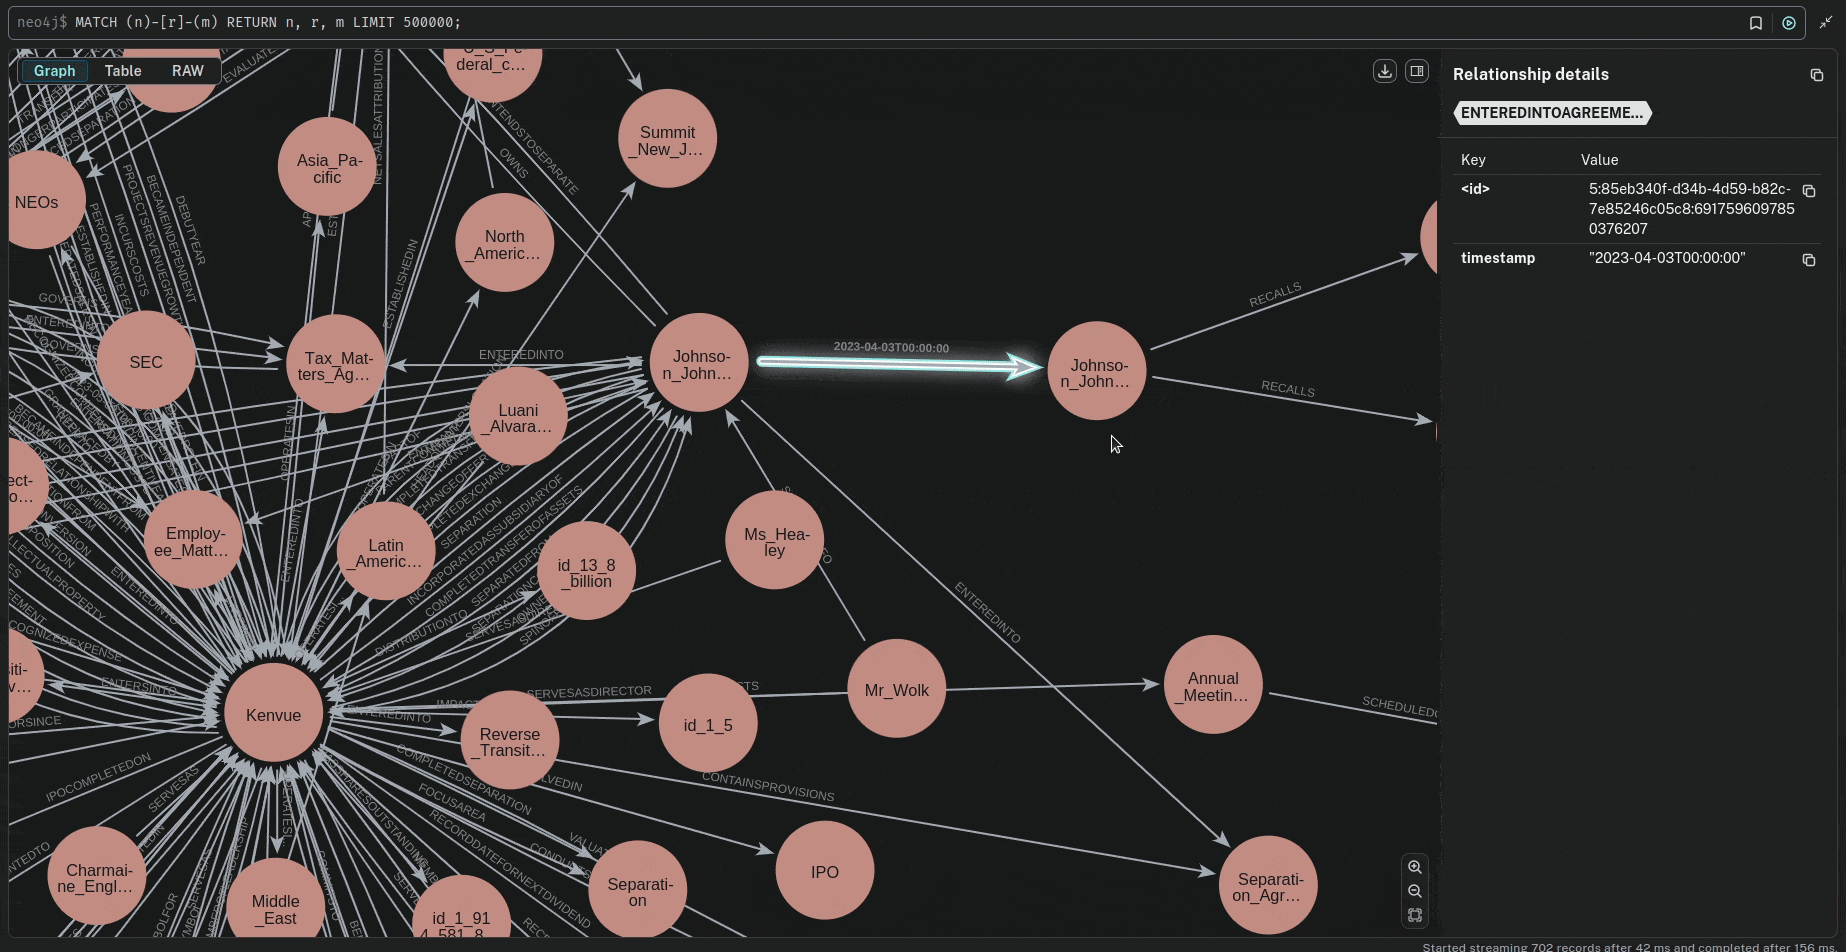
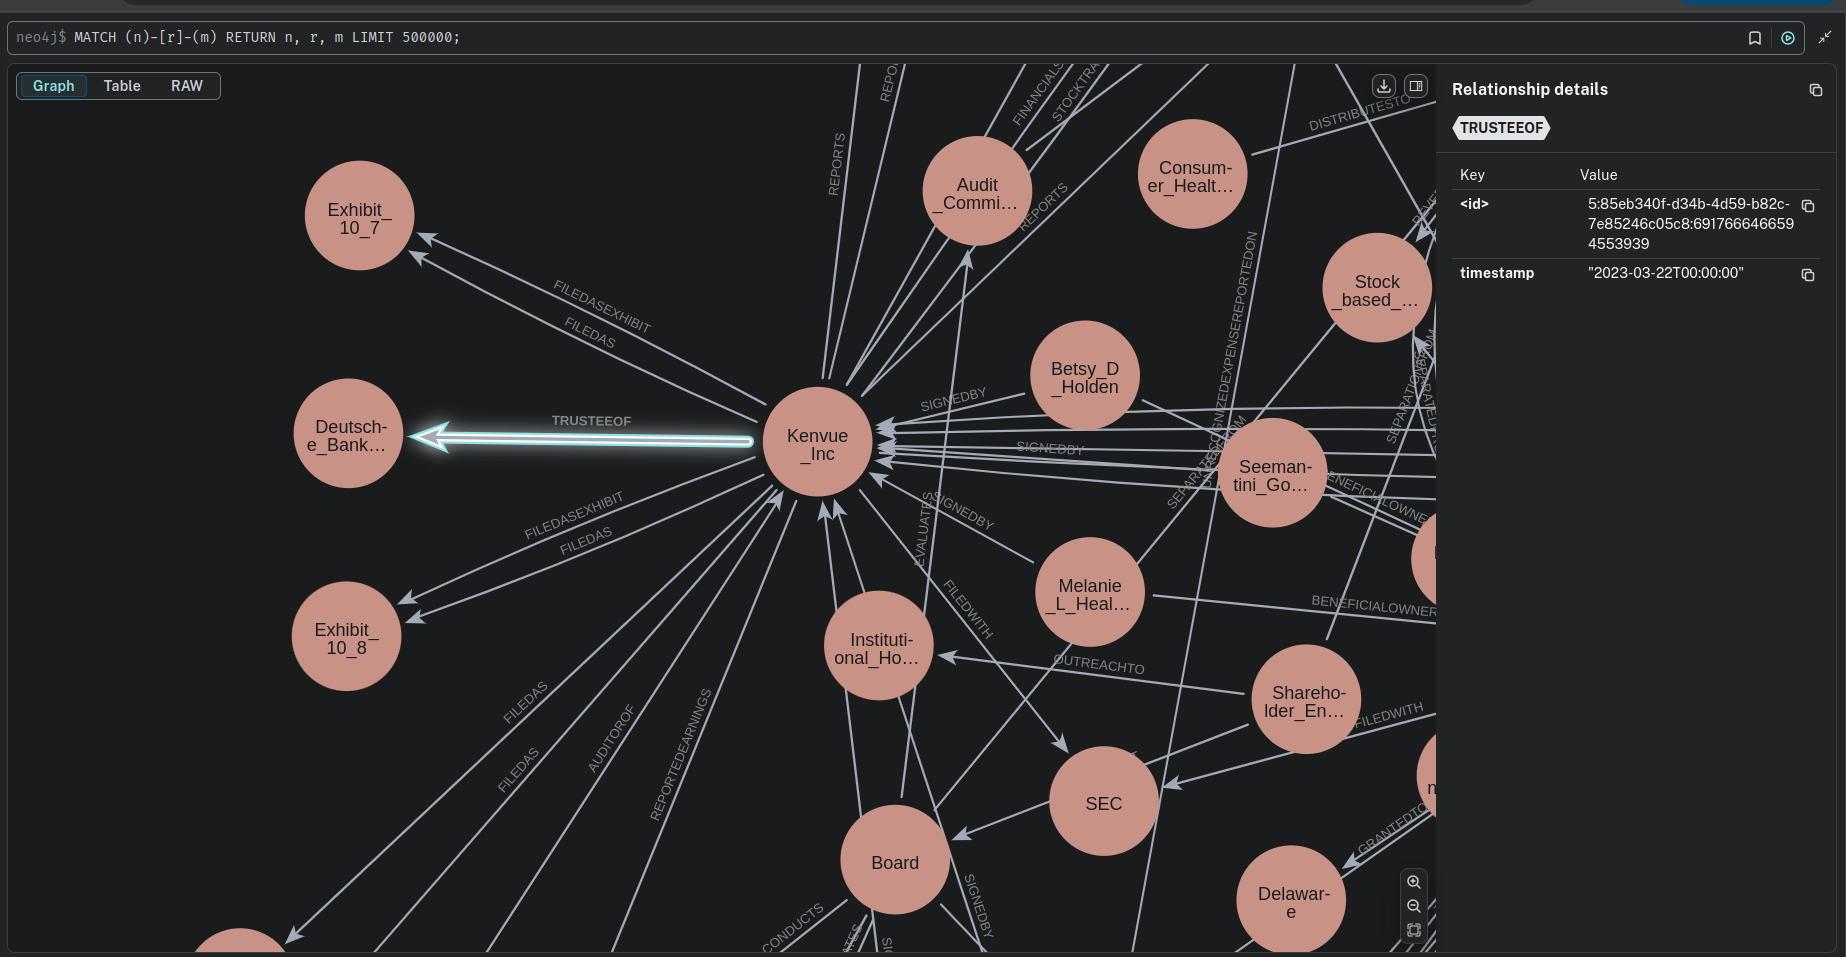
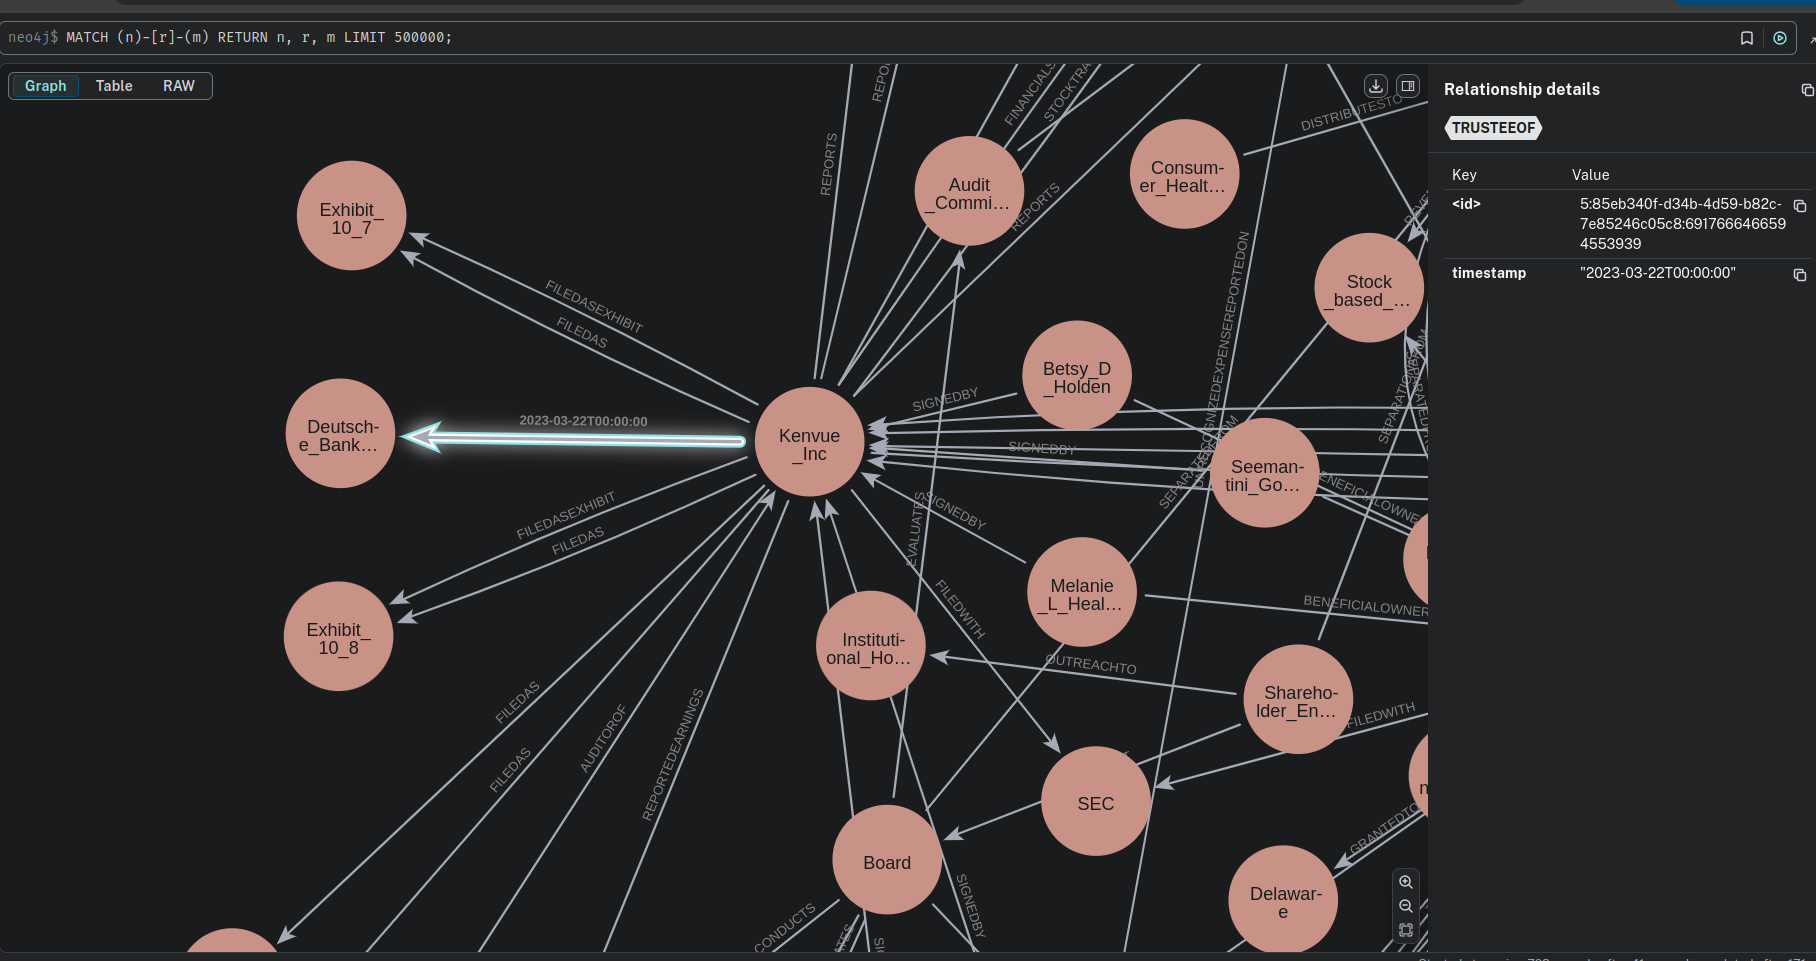


Add the unique relationships to a Neo4j graph. For each relationship, we generate a timestamp and add the triplet to the graph.

In [ ]:
import time

for rel in unique_relationships:
    current_time = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())
    timestamp = rel.timestamp if rel.timestamp is not None else current_time
    neo4j_graph.add_triplet(
        subj=rel.subj.id,
        obj=rel.obj.id,
        rel=rel.type,
        timestamp=timestamp,
    )

## 🔍 Querying the Knowledge Graph

Now that the knowledge graph is built, we can query it to retrieve time-based relationships.

In [ ]:
# Query all triplets
all_triplets = neo4j_graph.get_triplet()
if all_triplets:
    for triplet in all_triplets:
        print(
            f"Subject: {triplet['subj']}, Object: {triplet['obj']}, "
            f"Relationship: {triplet['rel']}, "
            f"Timestamp: {triplet['timestamp']}"
        )
else:
    print("No triplets found in the database.")

Subject: Kenvue, Object: Johnson_Johnson, Relationship: PARTOF, Timestamp: 2023-01-01T00:00:00
Subject: Kenvue, Object: Johnson_Johnson, Relationship: SEPARATION, Timestamp: 2023-08-01T00:00:00
Subject: Kenvue, Object: Johnson_Johnson, Relationship: INCORPORATEDASSUBSIDIARYOF, Timestamp: 2022-02-01T00:00:00
Subject: Kenvue_Inc, Object: Johnson_Johnson, Relationship: NETINVESTMENTFROM, Timestamp: 2023-12-31T00:00:00
Subject: Kenvue, Object: Johnson_Johnson, Relationship: SEPARATEDFROM, Timestamp: 2023-08-01T00:00:00
Subject: Mr_Wolk, Object: Johnson_Johnson, Relationship: SERVESASCFO, Timestamp: 2018-01-01T00:00:00
Subject: Kenvue, Object: Johnson_Johnson, Relationship: OWNEDBY, Timestamp: 2024-01-24T00:00:00
Subject: Kenvue, Object: Johnson_Johnson, Relationship: SPINOFFFROM, Timestamp: 2023-11-12T00:00:00
Subject: Johnson_Johnson, Object: Kenvue_Inc, Relationship: SPLITOFF, Timestamp: 2023-05-04T00:00:00
Subject: PricewaterhouseCoopers_LLP, Object: Kenvue_Inc, Relationship: AUDITOROF,

## Parameters Investigation.

- `max_characters`: The maximum number of characters in a chunk.
- `model`: The model to use for the knowledge graph agent. (TogetherAI or Samba Verse)

In [ ]:
elements = uio.parse_file_or_url(str(example_pdf_files[0]))
print(
    colorama.Fore.YELLOW
    + "The number of elements is: "
    + colorama.Fore.RESET
    + str(len(elements))
)

# Investigation of the chunk_elements function.
for max_characters in [512, 1024, 2048]:
    chunk_elements = uio.chunk_elements(
        elements,
        chunk_type="chunk_by_title",
        max_characters=max_characters,
    )
    print(
        colorama.Fore.BLUE
        + f"[max_characters: {max_characters:>4}] "
        + colorama.Fore.YELLOW
        + f"The number of chunk elements is: {len(chunk_elements)}"
        + colorama.Fore.RESET
    )

The number of elements is: 108
[max_characters:  512] The number of chunk elements is: 26
[max_characters: 1024] The number of chunk elements is: 13
[max_characters: 2048] The number of chunk elements is: 7


In [ ]:
limited_chunk_elements = uio.chunk_elements(
    elements, chunk_type="chunk_by_title", max_characters=1000
)
print(len(limited_chunk_elements))
print(limited_chunk_elements[0].text)

13
Kenvue Inc. (KVUE)

Updated November 8th, 2024 by Nathan Parsh Key Metrics

Current Price: $23.48 5 Year CAGR Estimate: -0.3% Market Cap: $45 B Fair Value Price: $16.10 5 Year Growth Estimate: 3.0% Ex-Dividend Date: 11/13/24 % Fair Value: 146% 5 Year Valuation Multiple Estimate: -7.3% Dividend Payment Date: 11/27/24 Dividend Yield: 3.5% 5 Year Price Target $19 Years Of Dividend Growth: 62 Dividend Risk Score: A Retirement Suitability Score: A Rating: Sell


In [ ]:
print(len(limited_chunk_elements[0].text))
print(limited_chunk_elements[0].text)

459
Kenvue Inc. (KVUE)

Updated November 8th, 2024 by Nathan Parsh Key Metrics

Current Price: $23.48 5 Year CAGR Estimate: -0.3% Market Cap: $45 B Fair Value Price: $16.10 5 Year Growth Estimate: 3.0% Ex-Dividend Date: 11/13/24 % Fair Value: 146% 5 Year Valuation Multiple Estimate: -7.3% Dividend Payment Date: 11/27/24 Dividend Yield: 3.5% 5 Year Price Target $19 Years Of Dividend Growth: 62 Dividend Risk Score: A Retirement Suitability Score: A Rating: Sell


In [ ]:
llama_kg_result = llama_405b_kg_agent.run(
    limited_chunk_elements[0], parse_graph_elements=True
)

In [ ]:
print(len(llama_kg_result.nodes))
print(llama_kg_result.nodes)

17
[Node(id='Kenvue Inc.', type="Organization', ticker='KVUE", properties={'source': 'agent_created'}), Node(id='Nathan Parsh', type='Person', properties={'source': 'agent_created'}), Node(id='$19.15', type="Price', description='Current Price", properties={'source': 'agent_created'}), Node(id='5.5%', type="Growth Rate', description='5 Year CAGR Estimate", properties={'source': 'agent_created'}), Node(id='$37 B', type='Market Capitalization', properties={'source': 'agent_created'}), Node(id='$17.78', type="Price', description='Fair Value Price", properties={'source': 'agent_created'}), Node(id='3.0%', type="Growth Rate', description='5 Year Growth Estimate", properties={'source': 'agent_created'}), Node(id='11/07/23', type="Date', description='Ex-Dividend Date", properties={'source': 'agent_created'}), Node(id='108%', type="Valuation', description='% Fair Value", properties={'source': 'agent_created'}), Node(id='-1.5%', type="Valuation Multiple', description='5 Year Valuation Multiple E

In [ ]:
together_kg_result = together_kg_agent.run(
    limited_chunk_elements[0], parse_graph_elements=True
)

In [ ]:
print(len(together_kg_result.nodes))
print(together_kg_result.nodes)

18
[Node(id='Kenvue Inc.', type='Organization', properties={'source': 'agent_created'}), Node(id='Nathan Parsh', type='Person', properties={'source': 'agent_created'}), Node(id='$19.15', type='Price', properties={'source': 'agent_created'}), Node(id='5.5%', type='CAGR', properties={'source': 'agent_created'}), Node(id='$37 B', type='MarketCap', properties={'source': 'agent_created'}), Node(id='$17.78', type='FairValuePrice', properties={'source': 'agent_created'}), Node(id='3.0%', type='GrowthEstimate', properties={'source': 'agent_created'}), Node(id='11/07/23', type='ExDividendDate', properties={'source': 'agent_created'}), Node(id='108%', type='FairValue', properties={'source': 'agent_created'}), Node(id='-1.5%', type='ValuationMultipleEstimate', properties={'source': 'agent_created'}), Node(id='11/22/23', type='DividendPaymentDate', properties={'source': 'agent_created'}), Node(id='4.2%', type='DividendYield', properties={'source': 'agent_created'}), Node(id='$21', type='PriceTarge

## 🌟 Highlights

This notebook has guided you through setting up and running a dynamic knowledge graph construction workflow using CAMEL's Knowledge Graph Agent and Neo4j. You can adapt and expand this example for various other scenarios requiring dynamic graph generation and querying.

Key tools utilized in this notebook include:

- **CAMEL**: A powerful multi-agent framework that enables the construction of knowledge graphs from unstructured data.
- **Neo4j**: A graph database used to store and query the knowledge graph.
- **Together and SambaVerse Models**: Large language models used to generate the knowledge graph from parsed documents.
- **Deduplication**: Techniques to ensure the uniqueness of nodes and relationships in the graph.

This comprehensive setup allows you to adapt and expand the example for various scenarios requiring dynamic graph generation and querying.

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>